In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install netcdf4

     |████████████████████████████████| 4.1MB 2.9MB/s 
     |████████████████████████████████| 317kB 48.2MB/s 


In [0]:
# Import every package
#from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm


In [0]:
def POD(confmat):
  return confmat[0,0]/(confmat[0,0]+confmat[1,0])

def FAR(confmat):
  return confmat[0,1]/(confmat[0,0]+confmat[0,1])

def PSS(confmat):
  return ((confmat[0,0]*confmat[1,1])-(confmat[0,1]*confmat[1,0]))/((confmat[0,0]+confmat[1,0])*(confmat[0,1]+confmat[1,1]))

In [0]:
shipdf = pd.read_csv('/content/drive/My Drive/training_dataset/prcp_all.csv')

In [0]:
shipdf.head()

,key_0,id_x,clat_x,clon_x,RHOUR,vmax,prcp,dvmax_y,MSLP,PER,SHRD,NOHC,SHRG,TPWC,TADV,PSLV
0,1998-07-28 00:00:00,b'bal011998',11.30,-25.400000,-12.0,25.0,0.338266,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0
1,1998-07-28 00:00:00,b'bal011998',11.50,-26.299999,-9.0,25.0,0.411434,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0
2,1998-07-28 00:00:00,b'bal011998',11.70,-27.200001,-6.0,25.0,0.353618,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0
3,1998-07-28 00:00:00,b'bal011998',11.95,-28.200001,-3.0,25.0,0.351601,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0
4,1998-07-28 00:00:00,b'bal011998',12.20,-29.200001,0.0,25.0,0.395761,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0


In [0]:
shipdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27989 entries, 0 to 27988
Data columns (total 16 columns):
key_0      27989 non-null object
id_x       27989 non-null object
clat_x     27989 non-null float64
clon_x     27989 non-null float64
RHOUR      27989 non-null float64
vmax       27989 non-null float64
prcp       27989 non-null float64
dvmax_y    27989 non-null float64
MSLP       27989 non-null float64
PER        27989 non-null float64
SHRD       27989 non-null float64
NOHC       27989 non-null float64
SHRG       27989 non-null float64
TPWC       27989 non-null float64
TADV       27989 non-null float64
PSLV       27989 non-null float64
dtypes: float64(14), object(2)
memory usage: 3.4+ MB


In [0]:
# Turn dvmax to RI
def ri(x):
    if x>=25:
        return 1
    else:
        return 0
shipdf['RI']=shipdf['dvmax_y'].apply(ri)

In [0]:
shipdf.columns

Index(['key_0', 'id_x', 'clat_x', 'clon_x', 'RHOUR', 'vmax', 'prcp', 'dvmax_y',
       'MSLP', 'PER', 'SHRD', 'NOHC', 'SHRG', 'TPWC', 'TADV', 'PSLV', 'RI'],
      dtype='object')

In [0]:
shipdf.corr()['dvmax_y'].sort_values(ascending=True)

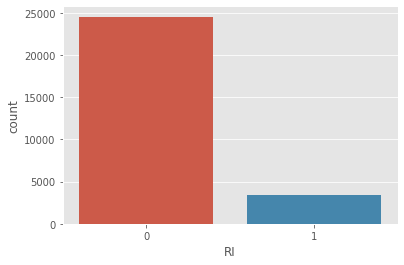

In [0]:
# imbalance data
sns.countplot('RI',data=shipdf)

In [0]:
y=shipdf['RI']
X=shipdf.drop(['key_0','RI','id_x','dvmax_y'],axis=1)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

# X=pd.DataFrame(X_ros, columns=['clat_x', 'clon_x', 'RHOUR', 'vmax', 'prcp',
#        'MSLP', 'PER', 'SHRD', 'NOHC', 'SHRG', 'TPWC', 'TADV', 'PSLV'])

# y=pd.DataFrame(y_ros,columns=['RI'])

21107 new random picked points


In [0]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=21)

logreg = LogisticRegression(C=2.64,penalty='l1')
logreg.fit(X_train, y_train)

In [0]:
# Create the hyperparameter grid
c_space = np.logspace(0, 4, 20)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

log_grs = GridSearchCV(logreg,param_grid,cv=5)
# Fit grid search
best_model = log_grs.fit(X_train, y_train)

In [0]:
# View best hyperparameters
print("Tuned Logistic Regression Parameter: {}".format(log_grs.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(log_grs.best_score_))

In [0]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [0]:
confusion_matrix_prcp = confusion_matrix(y_test, y_pred)
confusion_matrix_prcp

array([[5125, 2210],
       [1438, 5956]])

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      7320
           1       0.73      0.81      0.77      7409

    accuracy                           0.76     14729
   macro avg       0.76      0.76      0.76     14729
weighted avg       0.76      0.76      0.76     14729



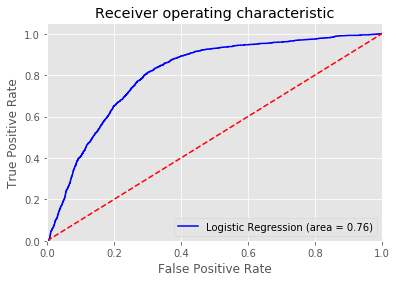

In [0]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc,c='blue')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1))
# Accuracy with all variables: 0.8302658486707567
cm = confusion_matrix(y_test, y_pred1)
print(cm)

Accuracy: 0.9945218530427533
[[7401   24]
 [  22  950]]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
clf2 = DecisionTreeClassifier(criterion="entropy", max_depth=6)
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
# Accuracy with all variables: 0.8568507157464212
cm2 = confusion_matrix(y_test, y_pred2)
print(cm2)

Accuracy: 0.8880552578301775
[[7412   13]
 [ 927   45]]


In [0]:
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
tree_cv = RandomizedSearchCV(clf, param_dist, cv=5)
tree_cv.fit(X_train,y_train)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3}
Best score is 0.8783841856467555


In [0]:
sc = StandardScaler()
X_train2 = sc.fit_transform(X_train)
X_test2 = sc.transform(X_test)
clf3 = DecisionTreeClassifier(criterion = 'gini', max_depth = None, max_features=2, min_samples_leaf=8)
clf3.fit(X_train2, y_train)
y_pred3 = clf3.predict(X_test2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred3))

Accuracy: 0.9404549243777539


In [0]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred4 = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred4))
print("Tuned Model Parameters: {}".format(cv.best_params_))

In [0]:
# SVC model based on best params from gridsearch
svc = SVC(C=100, gamma=0.01)
svc.fit(X_train, y_train)
y_pred5 = svc.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(svc.score(X_test, y_test)))
cm3 = confusion_matrix(y_test, y_pred2)
cm3

Accuracy: 0.9965463856139097


array([[7412,   13],
       [ 927,   45]])

In [0]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)
y_pred6 = forest.predict(X_test)
print("Accuracy: {}".format(forest.score(X_test, y_test)))
cm4 = confusion_matrix(y_test,y_pred6)
cm4

Accuracy: 0.9979754674288437


array([[7425,    0],
       [  17,  955]])

In [0]:
forest2 = RandomForestClassifier(n_estimators=100, criterion="entropy")
forest2.fit(X_train, y_train)
y_pred7 = forest2.predict(X_test)
print("Accuracy: {}".format(forest2.score(X_test, y_test)))
cm5 = confusion_matrix(y_test,y_pred7)
cm5

Accuracy: 0.9982136477313326


array([[7425,    0],
       [  15,  957]])

In [0]:
print("POD for Logistic Model {}".format(POD(confusion_matrix_prcp)))
print("FAR for Logistic Model {}".format(FAR(confusion_matrix_prcp)))
print("PSS for Logistic Model {}\n".format(PSS(confusion_matrix_prcp)))
print("POD for First Decision Tree Model {}".format(POD(cm)))
print("FAR for First Decision Tree Model {}".format(FAR(cm)))
print("PSS for First Decision Tree Model {}\n".format(PSS(cm)))
print("POD for Second Decision Tree Model {}".format(POD(cm2)))
print("FAR for Second Decision Tree Model {}".format(FAR(cm2)))
print("PSS for Second Decision Tree Model {}\n".format(PSS(cm2)))
print("POD for SVC Model {}".format(POD(cm3)))
print("FAR for SVC Model {}".format(FAR(cm3)))
print("PSS for SVC Model {}\n".format(PSS(cm3)))
print("POD for 1st Random Forest Model {}".format(POD(cm4)))
print("FAR for 1st Random Forest Model {}".format(FAR(cm4)))
print("PSS for 1st Random Forest Model {}\n".format(PSS(cm4)))
print("POD for 2nd Random Forest Model {}".format(POD(cm5)))
print("FAR for 2nd Random Forest Model {}".format(FAR(cm5)))
print("PSS for 2nd Random Forest Model {}\n".format(PSS(cm5)))

POD for Logistic Model 0.7808928843516685
FAR for Logistic Model 0.3012951601908657
PSS for Logistic Model 0.5102585468547299

POD for First Decision Tree Model 0.9970362387174997
FAR for First Decision Tree Model 0.0032323232323232323
PSS for First Decision Tree Model 0.9723955816333107

POD for Second Decision Tree Model 0.8888355917975777
FAR for Second Decision Tree Model 0.001750841750841751
PSS for Second Decision Tree Model 0.6646976607630949

POD for SVC Model 0.8888355917975777
FAR for SVC Model 0.001750841750841751
PSS for SVC Model 0.6646976607630949

POD for 1st Random Forest Model 0.9977156678312281
FAR for 1st Random Forest Model 0.0
PSS for 1st Random Forest Model 0.9977156678312281

POD for 2nd Random Forest Model 0.9979838709677419
FAR for 2nd Random Forest Model 0.0
PSS for 2nd Random Forest Model 0.9979838709677419



In [0]:
forest.feature_importances_

array([0.12976801, 0.09079339, 0.14125207, 0.13023007, 0.14020665,
       0.14143869, 0.0931392 , 0.13317192])

In [0]:
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)
feature_importances

,importance
TPWC,0.141439
SHRD,0.141252
SHRG,0.140207
PSLV,0.133172
NOHC,0.130230
MSLP,0.129768
TADV,0.093139
PER,0.090793


In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion':["gini", "entropy"]}
forest_cv = RandomizedSearchCV(forest, random_grid, cv=5)
forest_cv.fit(X_train, y_train)
print("Tuned Decision Tree Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

In [0]:
knn_ri = KNeighborsClassifier()
knn_ri.fit(X_train, y_train)
y_pred13 = knn_ri.predict(X_test)
print("Accuracy: {}".format(knn_ri.score(X_test, y_test)))
cm9 = confusion_matrix(y_test, y_pred13)
cm9

Accuracy: 0.9702918874000208


array([[942,   0,   0, ...,   0,   0,   0],
       [  0, 972,   0, ...,   0,   0,   0],
       [  0,   0, 951, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 915,   0,   0],
       [  0,   0,   0, ...,   0, 955,   0],
       [  0,   0,   0, ...,   0,   0, 975]])

In [0]:
print("POD for KNN Model {}".format(POD(cm9)))
print("FAR for KNN Model {}".format(FAR(cm9)))
print("PSS for KNN Model {}\n".format(PSS(cm9)))

POD for KNN Model 1.0
FAR for KNN Model 0.0
PSS for KNN Model 1.0



# **Dependent Variable: dvmax**

In [0]:
shipdf.head()

,key_0,id_x,clat_x,clon_x,RHOUR,vmax,prcp,dvmax_y,MSLP,PER,SHRD,NOHC,SHRG,TPWC,TADV,PSLV,RI
0,1998-07-28 00:00:00,b'bal011998',11.30,-25.400000,-12.0,25.0,0.338266,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0,0
1,1998-07-28 00:00:00,b'bal011998',11.50,-26.299999,-9.0,25.0,0.411434,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0,0
2,1998-07-28 00:00:00,b'bal011998',11.70,-27.200001,-6.0,25.0,0.353618,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0,0
3,1998-07-28 00:00:00,b'bal011998',11.95,-28.200001,-3.0,25.0,0.351601,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0,0
4,1998-07-28 00:00:00,b'bal011998',12.20,-29.200001,0.0,25.0,0.395761,10.0,1009.0,0.0,8.6,21.0,20.5,56.9,-6.0,494.0,0


In [0]:
y=shipdf['dvmax_y']
X=shipdf.drop(['id_x','dvmax_y','RI','key_0'],axis=1)

from imblearn.over_sampling import SMOTE

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)


In [0]:
def y_RI(y):
  return [1 if x>=25 else 0 for x in y.tolist()]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.3, random_state=3)
y_test_RI = y_RI(y_test)

In [0]:
knn1 = KNeighborsRegressor(n_neighbors=7)
knn1.fit(X_train, y_train)
y_pred9 = knn1.predict(X_test)
y_pred9_RI = y_RI(y_pred9)
cm7 = confusion_matrix(y_test_RI, y_pred9_RI)
cm7

In [0]:
print("POD for 1st KNN Model {}".format(POD(cm7)))
print("FAR for 1st KNN Model {}".format(FAR(cm7)))
print("PSS for 1st KNN Model {}\n".format(PSS(cm7)))

POD for 1st KNN Model 0.8925281473899693
FAR for 1st KNN Model 0.01245753114382786
PSS for 1st KNN Model 0.3687186235804455



In [0]:
params = {'n_neighbors': randint(1,8),
          'weights': ['uniform','distance'],
          'algorithm': ['auto', 'brute']}
knn1_cv = RandomizedSearchCV(knn1, params, cv=5)
knn1_cv.fit(X_train, y_train)


In [0]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred10 = reg.predict(X_test)
print("Accuracy: {}".format(reg.score(X_test, y_test)))
cm8 = confusion_matrix(y_RI(y_test), y_RI(y_pred10))
cm8

Accuracy: 0.6875551249265722


array([[21793,  3205],
       [ 2805, 10705]])

In [0]:
print('intercept:', reg.intercept_)
print('slope:', reg.coef_)

intercept: -1101.8073980557308
slope: [-2.47386122e-01  1.41069363e-01  2.18568308e-02 -2.93433165e-01
  2.93211165e+01  1.24735450e+00 -8.35547601e-02 -1.27627367e+00
  1.90542872e-01 -3.28308294e-01  4.82554269e-01 -3.19006874e-01
 -1.76452609e-01]


In [0]:
ridge1 = Ridge(normalize=True)
ridge1.fit(X_train, y_train)
y_pred11 = ridge1.predict(X_test)
print("Accuracy: {}".format(reg.score(X_test, y_test)))
confusion_matrix(y_RI(y_test), y_RI(y_pred11))

Accuracy: 0.6875551249265722


array([[23510,  1488],
       [ 6863,  6647]])

In [0]:
lasso1 = Lasso()
lasso1.fit(X_train, y_train)
y_pred12 = lasso1.predict(X_test)
print("Accuracy: {}".format(reg.score(X_test, y_test)))
confusion_matrix(y_RI(y_test), y_RI(y_pred12))

Accuracy: 0.6875551249265722


array([[21700,  3298],
       [ 2906, 10604]])

In [0]:
elasticnet = ElasticNet()
elasticnet.fit(X_train, y_train)
y_pred14 = elasticnet.predict(X_test)
print("Accuracy: {}".format(elasticnet.score(X_test, y_test)))
cm10 = confusion_matrix(y_RI(y_test), y_RI(y_pred14))
cm10

Accuracy: 0.6802071239543102


array([[21697,  3301],
       [ 2904, 10606]])